In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
pokemon_data = pd.read_csv('/content/Pokemon.csv')

In [6]:
pokemon_data.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [7]:
print(pokemon_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB
None


In [8]:
print(pokemon_data.isnull().sum())

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64


In [9]:
pokemon_data = pokemon_data.drop(columns=['Type 2','#'])

The Type 2 column is missing 386 values out of 800 entries, meaning nearly 48% of the data in this column is absent. Since we’re using stats to predict legendary status, we can safely exclude Type 2 as it doesn’t add meaningful value to the prediction and isn’t relevant to our analysis.

In [10]:
pokemon_data.head()

,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,309,39,52,43,60,50,65,1,False


In [11]:
name_duplicates = pokemon_data['Name'].duplicated().sum()
print(f"Total duplicate names: {name_duplicates}")

Total duplicate names: 0


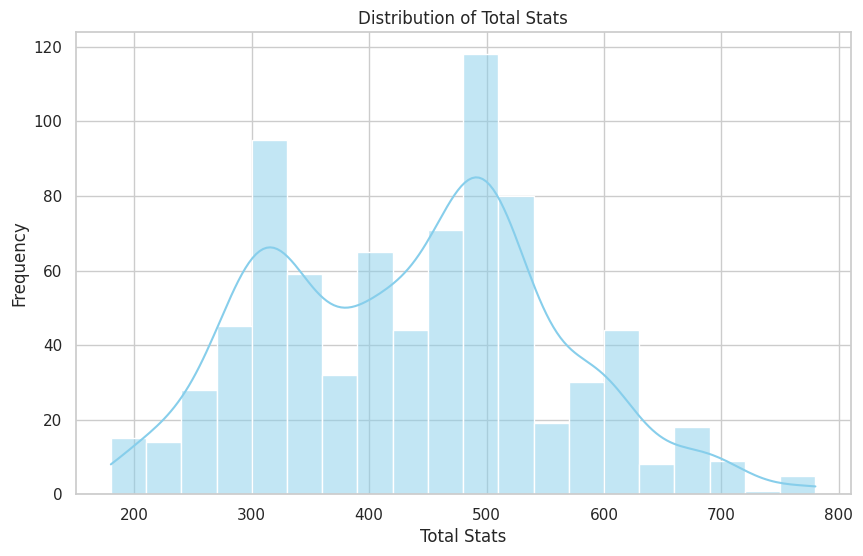

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(pokemon_data['Total'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Total Stats")
plt.xlabel("Total Stats")
plt.ylabel("Frequency")
plt.show()

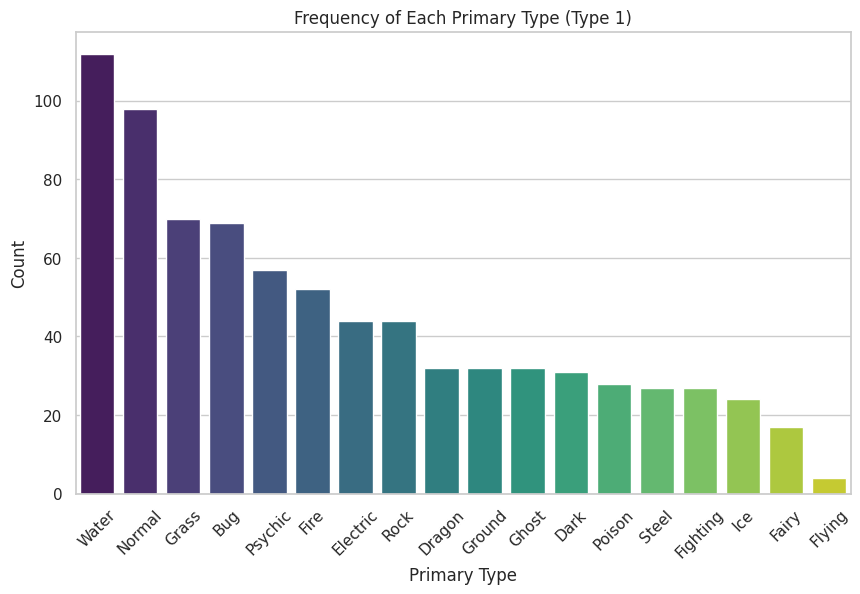

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=pokemon_data, x='Type 1', order=pokemon_data['Type 1'].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Frequency of Each Primary Type (Type 1)")
plt.xlabel("Primary Type")
plt.ylabel("Count")
plt.show()

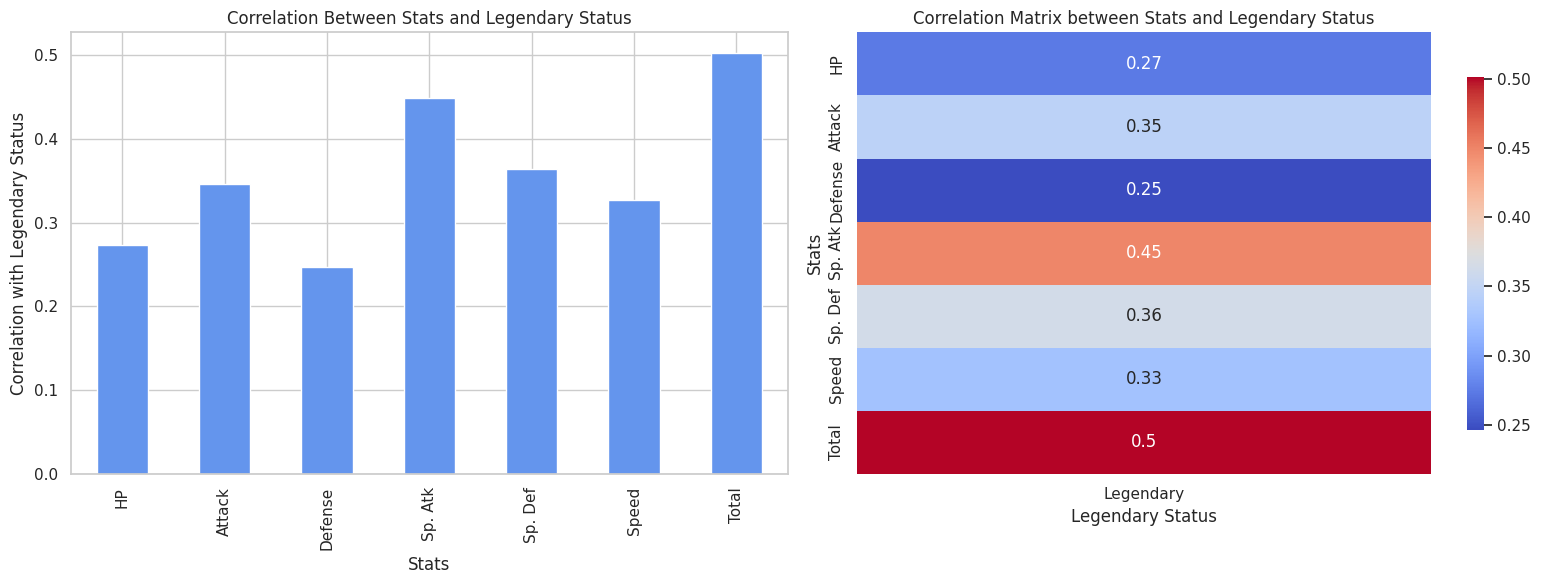

In [14]:
# Calculate correlation matrix between stats and the 'Legendary' status
correlation_legendary = pokemon_data[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Total', 'Legendary']].corr()

# Extract the correlations of each stat with 'Legendary' for easier interpretation
legendary_corr = correlation_legendary['Legendary'].drop('Legendary')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar plot of correlations with Legendary status
legendary_corr.plot(kind='bar', color='cornflowerblue', ax=axes[0])
axes[0].set_title("Correlation Between Stats and Legendary Status")
axes[0].set_xlabel("Stats")
axes[0].set_ylabel("Correlation with Legendary Status")

# Plot 2: Heatmap of correlation matrix with Legendary status
sns.heatmap(correlation_legendary[['Legendary']].drop(index='Legendary'), annot=True, cmap="coolwarm", cbar_kws={'shrink': .8}, ax=axes[1])
axes[1].set_title("Correlation Matrix between Stats and Legendary Status")
axes[1].set_xlabel("Legendary Status")
axes[1].set_ylabel("Stats")

# Display the plots
plt.tight_layout()
plt.show()


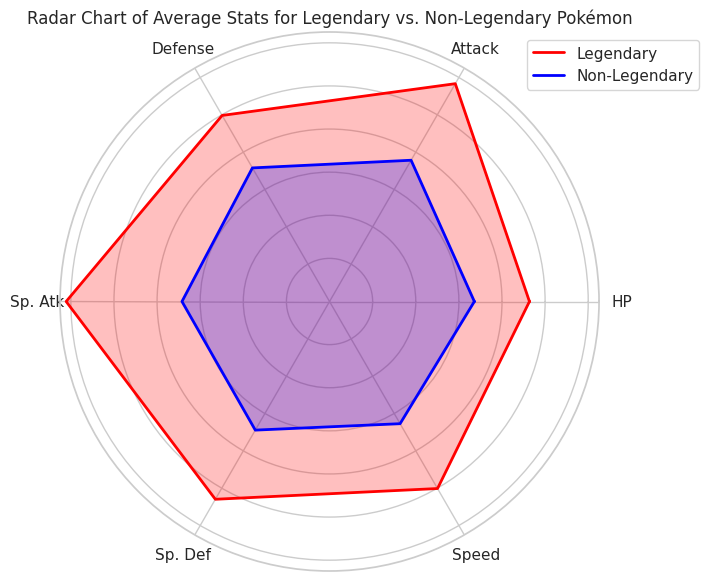

In [15]:
# Calculate the mean stats for Legendary and Non-Legendary Pokémon
legendary_stats = pokemon_data[pokemon_data['Legendary'] == True][['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].mean()
non_legendary_stats = pokemon_data[pokemon_data['Legendary'] == False][['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].mean()

# Radar chart setup
categories = list(legendary_stats.index)
num_vars = len(categories)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
stats_legendary = np.concatenate((legendary_stats, [legendary_stats[0]]))
stats_non_legendary = np.concatenate((non_legendary_stats, [non_legendary_stats[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
ax.fill(angles, stats_legendary, color='red', alpha=0.25)
ax.fill(angles, stats_non_legendary, color='blue', alpha=0.25)
ax.plot(angles, stats_legendary, color='red', linewidth=2, label='Legendary')
ax.plot(angles, stats_non_legendary, color='blue', linewidth=2, label='Non-Legendary')
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Position the legend outside the plot to the upper right
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title("Radar Chart of Average Stats for Legendary vs. Non-Legendary Pokémon")
plt.show()


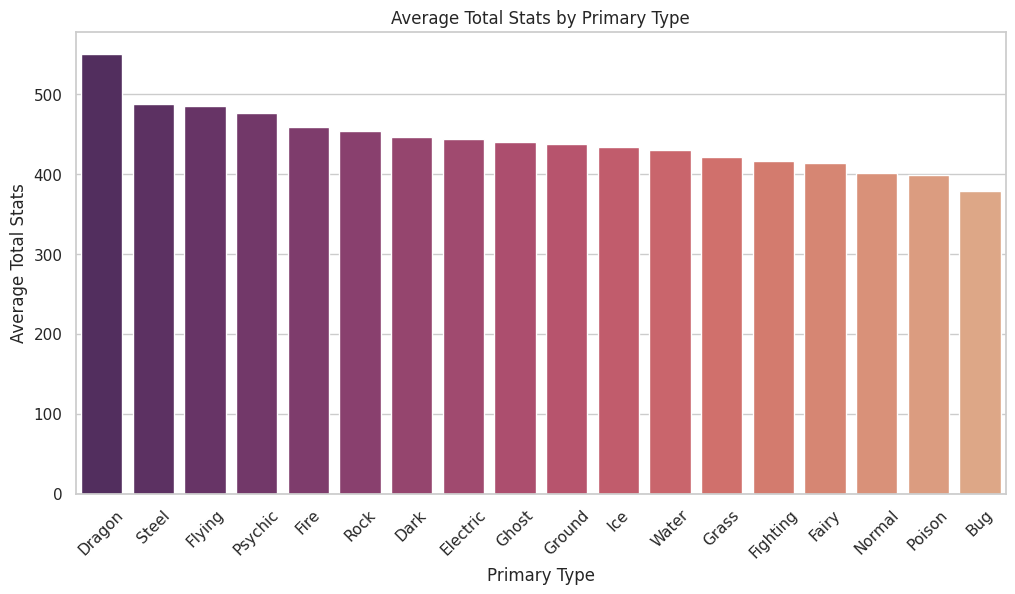

In [16]:
# Create a bar plot to show the average total stats by primary type
plt.figure(figsize=(12, 6))
sns.barplot(data=pokemon_data, x='Type 1', y='Total', ci=None, palette="flare_r", order=pokemon_data.groupby('Type 1')['Total'].mean().sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title("Average Total Stats by Primary Type")
plt.xlabel("Primary Type")
plt.ylabel("Average Total Stats")
plt.show()



In [17]:
# Select relevant features for the model
X = pokemon_data[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = pokemon_data['Legendary'].astype(int)  # Convert to binary (1 for Legendary, 0 for non-Legendary)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [19]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


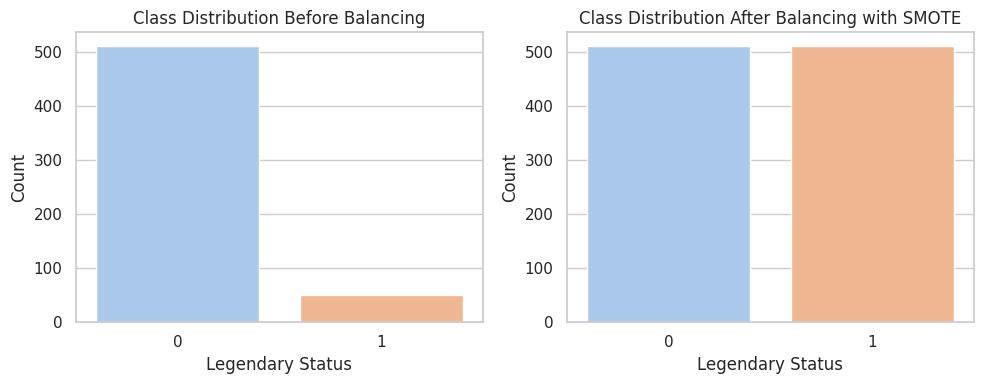

In [20]:


# Class distribution before balancing
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="pastel")
plt.title("Class Distribution Before Balancing")
plt.xlabel("Legendary Status")
plt.ylabel("Count")

# Class distribution after balancing
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced, palette="pastel")
plt.title("Class Distribution After Balancing with SMOTE")
plt.xlabel("Legendary Status")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [21]:
# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_balanced, y_train_balanced)


LogisticRegression(max_iter=1000, random_state=42)

In [22]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [23]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96       225
           1       0.48      1.00      0.65        15

    accuracy                           0.93       240
   macro avg       0.74      0.96      0.81       240
weighted avg       0.97      0.93      0.94       240

Confusion Matrix:
 [[209  16]
 [  0  15]]


In [24]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.65


In [25]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       225
           1       0.48      1.00      0.65        15

    accuracy                           0.93       240
   macro avg       0.74      0.96      0.81       240
weighted avg       0.97      0.93      0.94       240



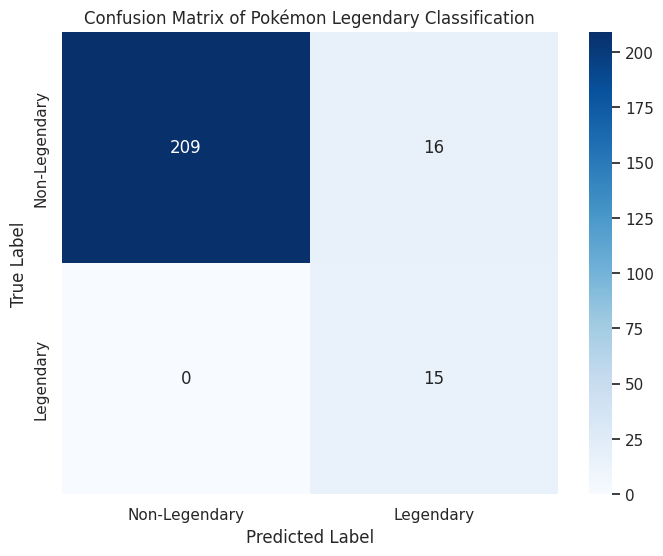

In [26]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Legendary", "Legendary"], yticklabels=["Non-Legendary", "Legendary"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Pokémon Legendary Classification")
plt.show()


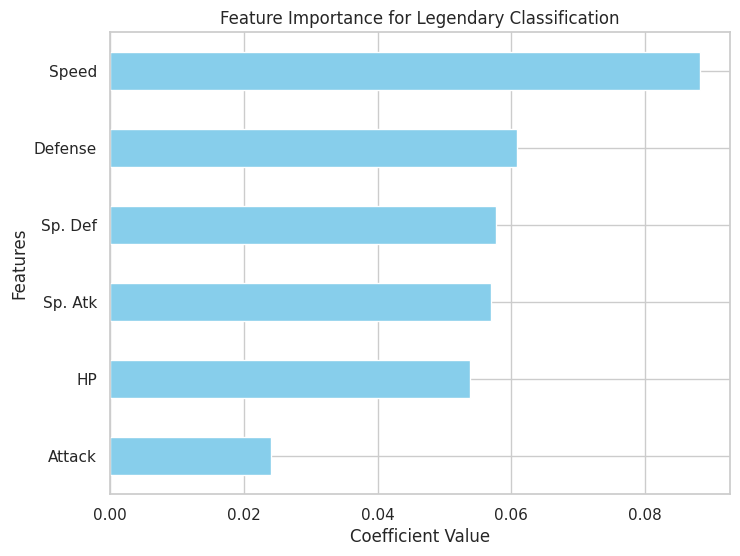

In [27]:
# Extract coefficients and feature names
feature_importance = pd.Series(model.coef_[0], index=X.columns).sort_values()

# Plot Feature Importance
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh', color='skyblue')
plt.title("Feature Importance for Legendary Classification")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()
